<a href="https://colab.research.google.com/github/siddhantkd/Hand-Gesture_DeepLearning/blob/main/Segmentation_ResidualFCN%2BASPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATALOADER

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS_Siddhant.zip'

In [8]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm

In [3]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = "/content/OUHANDS_Siddhant/training/colour"
maskpath = "/content/OUHANDS_Siddhant/training/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:03<00:00, 600.49it/s]


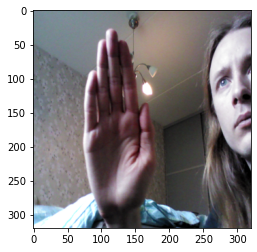

In [ ]:
plt.imshow(X_train[0])

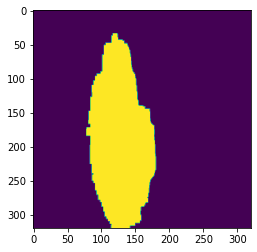

In [ ]:
plt.imshow(array_to_img(Y_train[0]))

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
print("X_train",X_train.shape)
print("Y_train", Y_train.shape)

X_train (2000, 320, 320, 3)
Y_train (2000, 320, 320, 1)


#SEGMENTATION 

In [4]:
#Import necessary libraries

import keras

import tensorflow as tf
from keras.datasets import mnist

from keras.models import Model,Input

from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [5]:
# Defining the Segmentation Model



class SegModel(object):
        def __init__(self, input_size):
            self.input_size=input_size
            self._build_model()
            

        def relu(self,x):
            return Activation('relu')(x)

        def ResidualNet(self,filters,s):
            def Res_unit(x):
              BottleN = int(filters / 4)
              b_filter = BottleN

              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)
              ident_map = x

              x = Conv2D(filters=b_filter, kernel_size=(1, 1), strides=(s, s))(x)
              
              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)

              x = Conv2D(filters=b_filter, kernel_size=(3, 3),  padding="same")(x)

              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)

              x = Conv2D(filters=filters, kernel_size=(1,1))(x)

              ident_map = Conv2D(filters,(1,1),strides=(s,s))(ident_map)
              
              out = keras.layers.add([ident_map,x])

              return out
            return Res_unit

        def Res_Group(self,nfilter,layers,_stride):
            def Res_unit(x):
                for i in range(layers):
                    if i==0:
                        x = self.ResidualNet(nfilter,_stride)(x)
                    else:
                        x = self.ResidualNet(nfilter,1)(x)
                                   
                              
                return x
            return Res_unit

        #-------------------Pyramid Dilated Convolution--------------------------------
        def ASPP(self,input_layer):
            l = BatchNormalization(axis=-1)(input_layer)
            l = self.relu(l)
            conv1 = l
            dconv_filters=32
            a1 = Conv2D(dconv_filters, 1, activation = 'relu', padding = 'same', dilation_rate = 1)(conv1)
            a2 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 3)(conv1)
            a3 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 6)(conv1)
            a4 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 12)(conv1)
            a5 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 18)(conv1)

            concat = keras.layers.concatenate([a1,a2,a3,a4,a5], axis = 3)  
            
            return concat


        def _build_model(self):
        #--------------------encoder---------    
            inp = Input(shape=(self.input_size))
            i = inp
            i = Conv2D(16,7,padding='same')(i)
        #----------------------------------------
            i = self.Res_Group(32,3,1)(i) 
        #----------------------------------------
            i = self.Res_Group(64,3,2)(i) 
        #---------------------------------------
            i = self.Res_Group(128,3,2)(i) 
            out_pdc2 = self.ASPP(i)
        #---------------------------------------

        #-----------------------decoder----------------
            i_dec = Dropout(0.15)(out_pdc2)

            conv_f = Conv2D(1,(1, 1), activation='sigmoid', padding='same')(i_dec)

            i_dec=keras.layers.UpSampling2D(size = (4,4), interpolation='bilinear')(conv_f)



            model = Model(inputs=inp, outputs=i_dec )

            self.model=model

#Training the Model

In [ ]:
!nvidia-smi

Sun Sep 26 18:03:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
input_size = (320,320,3)
SegM=SegModel(input_size)
model=SegM.model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

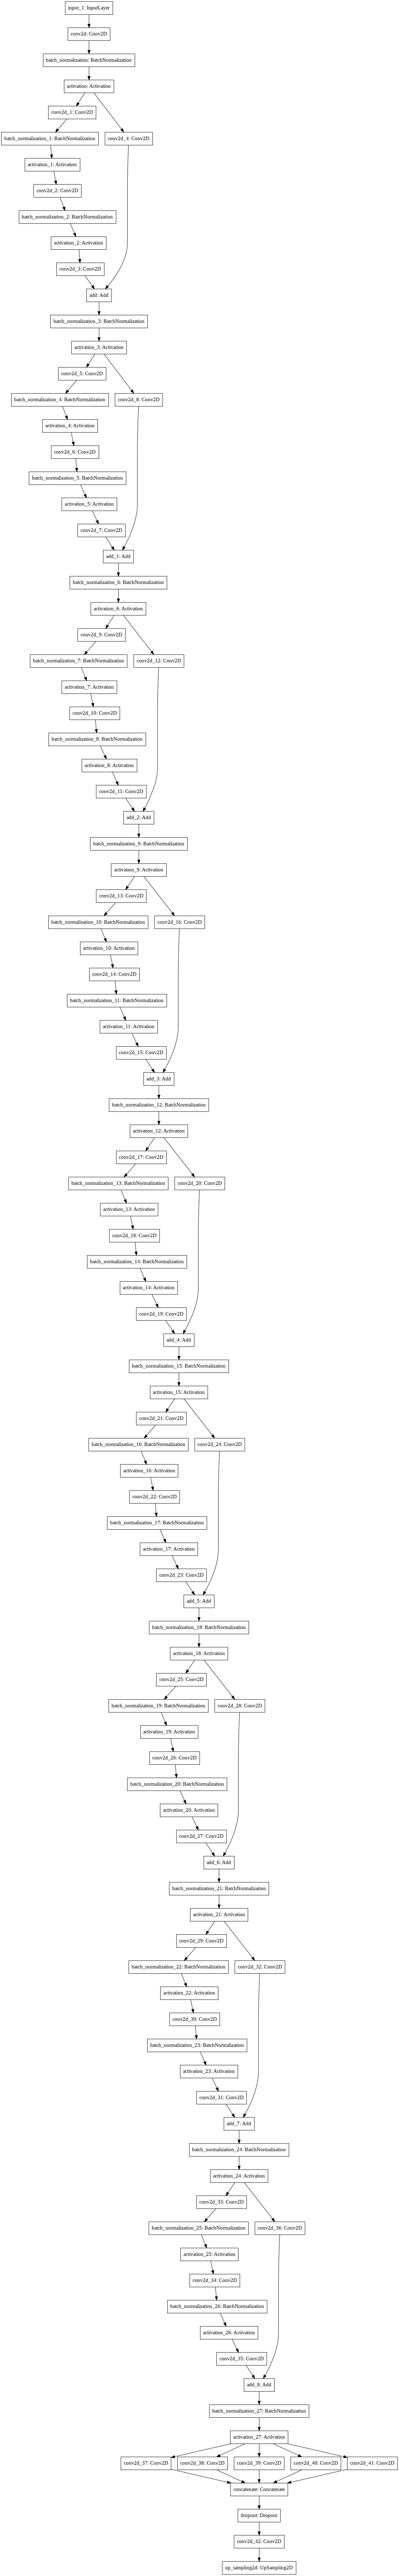

In [ ]:
#Our CNN model
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [8]:
_adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
)

In [9]:
model.compile(loss='binary_crossentropy',optimizer = _adam,metrics=['accuracy'])

###50 epochs

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

In [ ]:
#Model Checkpoint

checkpoint_path = "/content/drive/MyDrive/Ouhands_RGB_cp/FCN_Residual/50epochs"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h1 = model.fit(X_train, Y_train,validation_split=0.1, batch_size=8, epochs=50, verbose=1,callbacks=[model_checkpoint])

Epoch 1/50
225/225 [==============================] - 161s 546ms/step - loss: 0.1074 - accuracy: 0.9546 - val_loss: 0.1115 - val_accuracy: 0.9553

Epoch 00001: val_accuracy improved from -inf to 0.95530, saving model to /content/drive/MyDrive/Ouhands_RGB_cp/FCN_Residual/50epochs
Epoch 2/50
225/225 [==============================] - 121s 536ms/step - loss: 0.0609 - accuracy: 0.9737 - val_loss: 0.1103 - val_accuracy: 0.9578

Epoch 00002: val_accuracy improved from 0.95530 to 0.95777, saving model to /content/drive/MyDrive/Ouhands_RGB_cp/FCN_Residual/50epochs
Epoch 3/50
225/225 [==============================] - 120s 536ms/step - loss: 0.0505 - accuracy: 0.9775 - val_loss: 0.0831 - val_accuracy: 0.9666

Epoch 00003: val_accuracy improved from 0.95777 to 0.96661, saving model to /content/drive/MyDrive/Ouhands_RGB_cp/FCN_Residual/50epochs
Epoch 4/50
225/225 [==============================] - 119s 530ms/step - loss: 0.0450 - accuracy: 0.9798 - val_loss: 0.0482 - val_accuracy: 0.9790

Epoch 0

#### Plots

Text(0, 0.5, 'Training Error')

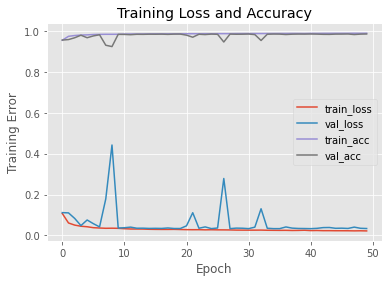

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0,N), h1.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h1.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h1.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h1.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

Text(0, 0.5, 'Validation Loss')

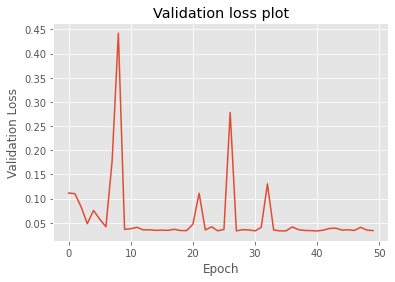

In [ ]:
plt.plot(np.arange(0,N), h1.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

Text(0, 0.5, 'Training Loss')

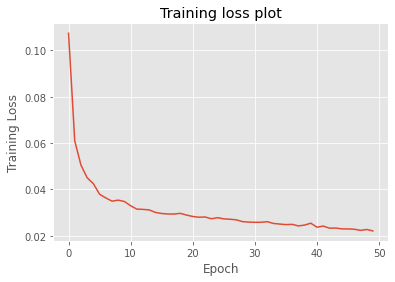

In [ ]:
plt.plot(np.arange(0,N), h1.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

#EVALUATION

## Test Data

In [9]:
path = "/content/OUHANDS_Siddhant/testing/colour"
maskpath = "/content/OUHANDS_Siddhant/testing/segmentation"

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:01<00:00, 571.78it/s]


## Define Evaluation Metrics

In [10]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [11]:
## F Score

def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

## Evaluations

In [12]:
checkpoint_path = "/content/drive/MyDrive/Ouhands_RGB_cp/FCN_Residual/50epochs"
model.load_weights(checkpoint_path)

In [13]:
## New F score
Y_pred=model.predict(X_test)
f=fscore(Y_pred,X_test,Y_test)
print("F score", f)

F score 0.9659042285156251


In [ ]:
## F Score

Y_pred=model.predict(X_test)
f=fscore(Y_pred,X_test,Y_test)
print("F score", f)

F score 0.9659042285156251


In [16]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7233405855331438


##Visualising the performance of our model

Text(0.5, 1.0, 'TEST IMAGE')

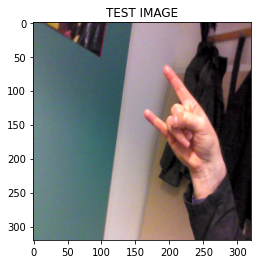

In [50]:
plt.grid(False)
plt.imshow(array_to_img(X_test[599]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

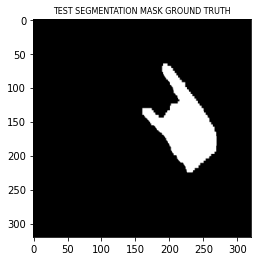

In [51]:
plt.imshow(array_to_img(Y_test[599]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

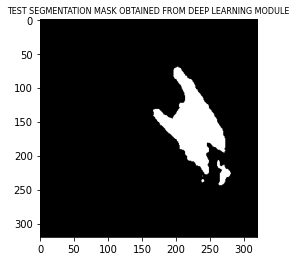

In [52]:
plt.imshow(array_to_img(Y_pred[599]), cmap = 'gray')
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)